In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, urllib, urllib3, time, warnings
from pvlib.solarposition import get_solarposition
from pvlib import irradiance
from matplotlib.collections import PolyCollection
import knmy
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

print('\014')
plt.close('all')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [2]:
# Convenience dict
number_to_month = { 
    1 : ['January', 31],
    2 : ['February', 28],
    3 : ['March', 31],
    4 : ['April', 30],
    5 : ['May', 31],
    6 : ['June', 30],
    7 : ['July', 31],
    8 : ['August', 31],
    9 : ['September', 30],
   10 : ['October', 31],
   11 : ['November', 30],
   12 : ['December', 31]
}

In [3]:
class Color:
    W       = '\033[0m'
    R       = '\033[1;31;48m'
    G       = '\033[32m'
    B       = '\033[34m'
    O       = '\033[33m'
    LB      = '\033[1;34;48m'
    P       = '\033[35m'
    C       = '\033[36m'
    WBLACK  = '\033[1;37;40m'
    WBLUE   = '\033[1;37;44m'
    END     = '\033[1;37;0m'
    WR      = '\033[1;37;41m'
    BG      = '\033[1;40;42m'

In [4]:
# Load KNMI data, combine YYYYMMDD and HH
start_date_UTC  = 2024020100
end_date_UTC    = 2025013123
visualisation_year = [2024]
visualisation_month = [12]
number_of_weather_station = 330
print(f'start date UTC = {str(start_date_UTC)}')
print(f'end date UTC = {str(end_date_UTC)}')

start date UTC = 2024020100
end date UTC = 2025013123


In [5]:
url = 'https://www.knmi.nl/nederland-nu/klimatologie/uurgegevens'
# Dutch: Uurvak u loopt van u - 1 UT tot u UT.
try:
    urllib.request.urlretrieve(url)
    disclaimer, stations, variables, df = knmy.knmy.get_hourly_data(
        stations = [number_of_weather_station], start = start_date_UTC, end = end_date_UTC,
        inseason = False, variables = ['WIND', 'TEMP', 'Q', 'SQ', 'VICL', 'P'], parse = True)
    # When KNMI is updating its data, the above statement will produce an empty dataframe.
    # In this case it's preferable to load the dataframe from the former successfull run.
    if df['YYYYMMDD'].isnull().values.any():
        print(Color.R + 'loading KNMI data from file ...' + Color.END)
        df = pd.read_csv('~/Documents/Soleil/Lectoraar-Internship/Solar-Panel-Project/Energy/year_data/df_KNMI.csv')
    else:
        station_name = stations['name'].values[0]
        print(f'Loading data from weather station: {station_name}')
        print('Saving KNMI data to file ...')
        df.to_csv('~/Documents/Soleil/Lectoraar-Internship/Solar-Panel-Project/Energy/data_experimenting/year_data/df_KNMI.csv')
except urllib.error.HTTPError as err:
    print(f'{url}: {err}')
    print(Color.R + 'loading KNMI data from file ...' + Color.END)
    df = pd.read_csv('~/Documents/Soleil/Lectoraar-Internship/Solar-Panel-Project/Energy/data_experimenting/year_data/df_KNMI.csv')

Loading data from weather station: Hoek van Holland
Saving KNMI data to file ...


In [6]:
df.head()

,STN,YYYYMMDD,HH,DD,FH,FF,FX,T,T10N,TD,Q,SQ,VV,N,U,P
0,330,20240201,1,250.0,100.0,100.0,150.0,90,NaN,84,0,0,NaN,NaN,96,10243.0
1,330,20240201,2,280.0,100.0,100.0,150.0,87,NaN,79,0,0,NaN,NaN,94,10250.0
2,330,20240201,3,330.0,90.0,70.0,120.0,72,NaN,50,0,0,NaN,NaN,85,10260.0
3,330,20240201,4,320.0,70.0,60.0,90.0,65,NaN,40,0,0,NaN,NaN,84,10269.0
4,330,20240201,5,310.0,70.0,70.0,100.0,66,NaN,38,0,0,NaN,NaN,82,10277.0


In [7]:
df["HH"] = df["HH"].astype(str).str.zfill(2)

In [8]:
drop_columns = ['DD', 'T10N', 'TD', 'VV', 'STN','N']
df = df.drop(columns = drop_columns)
print(df.head())

   YYYYMMDD  HH     FH     FF     FX   T  Q  SQ   U        P
0  20240201  01  100.0  100.0  150.0  90  0   0  96  10243.0
1  20240201  02  100.0  100.0  150.0  87  0   0  94  10250.0
2  20240201  03   90.0   70.0  120.0  72  0   0  85  10260.0
3  20240201  04   70.0   60.0   90.0  65  0   0  84  10269.0
4  20240201  05   70.0   70.0  100.0  66  0   0  82  10277.0


In [9]:
# New column names 
new_column_names = { 
    'YYYYMMDD': 'date',
    'HH' : 'hour',
    'FH' : 'average windspeed (m/s)',
    'FF' : 'windspeed previous 10 minuten (m/s)',
    'FX' : 'highest windspeed (m/s)',
    'T'  : 'temperature in degrees Celcius',
    'SQ' : 'duration of sunshine (h)',
    'Q'  : 'global radiation (in J/m^2)',    
    'P'  : 'air pressure (Pa)',
    'U'  : 'relative humidity (in percentages)'
}
df = df.rename(columns = new_column_names)

##### Adding a column for datetime that will be used for calculating the Solar Position

In [10]:
def parse_datetime(row):
    hour = int(row["hour"])
    date = pd.to_datetime(str(row["date"]), format="%Y%m%d")
    if hour == 24:
        return date + pd.Timedelta(days=1)
    else:
        return date + pd.Timedelta(hours=hour)

df["datetime"] = df.apply(parse_datetime, axis=1)
#df.set_index("datetime", inplace=True)

In [11]:
df.head()

,date,hour,average windspeed (m/s),windspeed previous 10 minuten (m/s),highest windspeed (m/s),temperature in degrees Celcius,global radiation (in J/m^2),duration of sunshine (h),relative humidity (in percentages),air pressure (Pa),datetime
0,20240201,01,100.0,100.0,150.0,90,0,0,96,10243.0,2024-02-01 01:00:00
1,20240201,02,100.0,100.0,150.0,87,0,0,94,10250.0,2024-02-01 02:00:00
2,20240201,03,90.0,70.0,120.0,72,0,0,85,10260.0,2024-02-01 03:00:00
3,20240201,04,70.0,60.0,90.0,65,0,0,84,10269.0,2024-02-01 04:00:00
4,20240201,05,70.0,70.0,100.0,66,0,0,82,10277.0,2024-02-01 05:00:00


In [12]:
# Group variables
windvariabelen = ['average windspeed (m/s)',
                  'windspeed previous 10 minuten (m/s)', 
                  'highest windspeed (m/s)' ]
temperature_variables = ['temperature in degrees Celcius'],
air_pressurevariabelen = ['air pressure (Pa)']
zonvariabelen = ['duration of sunshine (h)', 'global radiation (in J/m^2)']

# Physical constants
area_of_solar_panel = 2.45         ## area of one module [m^2]
efficiency_solar_panel = 0.20  ## efficiency of one solar panel [-]
number_of_solar_panels = 2   ## total number of solar panels used [-]
lat = 51.96811434560797             ## latitude of plant
lon = 4.095795682209092             ## longitude of plant
module = \
    {'theta_M': np.deg2rad(20),
     'azimuth': np.deg2rad(115)}

# Convert to S.I. units
for column in zonvariabelen:
    if column == 'duration of sunshine (h)':
        df[column] *= 0.10
    elif column == 'global radiation (in J/m^2)':
        df[column] *= 1e4

In [13]:
# Get the elevation of the module
def make_remote_request(url: str, params: dict):
    global response
    while True:
        try:
            response = requests.get(url + urllib.parse.urlencode(params))
        except (OSError, urllib3.exceptions.ProtocolError) as error:
            print(error)
            continue
        break

    return response

def elevation_function(lat, lon):
    url = 'https://api.opentopodata.org/v1/eudem25m?'
    params = {'locations': f"{lat},{lon}"}
    result = make_remote_request(url, params)
    if 'results' in result.json().keys():
        return_value = result.json()['results'][0]['elevation']
    else:
        return_value = None
    return return_value

In [14]:
elevation_module = elevation_function(lat, lon)
while elevation_module == None:
    time.sleep(0.40)
    elevation_module = elevation_function(lat, lon)

In [15]:
# Calculate the positions of the sun
date_time_or_doy = df['datetime'] 
solpos = get_solarposition(
    time = date_time_or_doy, latitude = lat,
    longitude = lon, altitude = elevation_module,
    pressure = df['air pressure (Pa)'].values, 
    temperature = df['temperature in degrees Celcius'].values) 

In [16]:
solpos.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
datetime,,,,,,
2024-02-01 01:00:00,143.162709,143.162709,-53.162709,-53.162709,25.600065,-13.406321
2024-02-01 02:00:00,137.699864,137.699864,-47.699864,-47.699864,46.486728,-13.412310
2024-02-01 03:00:00,130.125118,130.125118,-40.125118,-40.125118,63.429047,-13.418275
2024-02-01 04:00:00,121.419409,121.419409,-31.419409,-31.419409,77.487555,-13.424218
2024-02-01 05:00:00,112.242423,112.242423,-22.242423,-22.242423,89.834815,-13.430137


#### Adding 2 columns for calculated `zenith` and `azimuth`

In [17]:
df['solpos_zenith'] = solpos['zenith'].values
df['solpos_azimuth'] = solpos['azimuth'].values

In [18]:
# Orientation parameters
theta_M = module['theta_M']                     ## tilt angle module
az_M = module['azimuth']                        ## azimuth angle module

# Compute G_module, first decompose the ghi into dni and dhi
ghi = df['global radiation (in J/m^2)'].values  ## global horizontal irradiance in [J/m^2]
out_erbs = irradiance.erbs(ghi, solpos.zenith, solpos.index)
out_erbs = out_erbs.rename(columns = {'dni': 'dni_erbs', 'dhi': 'dhi_erbs'})
dni = out_erbs['dni_erbs'].values               ## direct normal irradiance. [J/m^2]
dhi = out_erbs['dhi_erbs'].values               ## diffuse horizontal irradiance in [J/m^2]
sky_model = 'isotropic'
poa = irradiance.get_total_irradiance(np.rad2deg(theta_M), np.rad2deg(az_M),
                         solpos.zenith, solpos.azimuth,
                         dni, ghi, dhi, dni_extra = None, airmass = None,
                         surface_type = 'sea',
                         model = sky_model)
G_module = poa['poa_global'].values

In [19]:
# Store into the dataframe
df['yield solar panel (kWh)'] = \
    (G_module * area_of_solar_panel * number_of_solar_panels * efficiency_solar_panel) / (1e3 * 3600 )
print("Last data frame after calculations/n")

Last data frame after calculations/n


In [20]:
df.sample(3)

,date,hour,average windspeed (m/s),windspeed previous 10 minuten (m/s),highest windspeed (m/s),temperature in degrees Celcius,global radiation (in J/m^2),duration of sunshine (h),relative humidity (in percentages),air pressure (Pa),datetime,solpos_zenith,solpos_azimuth,yield solar panel (kWh)
7522,20241210,11,100.0,100.0,130.0,56,130000.0,0.0,76,10316.0,2024-12-10 11:00:00,75.371157,171.299113,0.054979
3770,20240707,03,60.0,70.0,110.0,133,0.0,0.0,88,10094.0,2024-07-07 03:00:00,94.588569,43.391264,0.000000
569,20240224,18,70.0,70.0,100.0,68,0.0,0.0,76,9994.0,2024-02-24 18:00:00,97.921998,264.762971,0.000000


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 8784 non-null   int64         
 1   hour                                 8784 non-null   object        
 2   average windspeed (m/s)              8754 non-null   float64       
 3   windspeed previous 10 minuten (m/s)  8754 non-null   float64       
 4   highest windspeed (m/s)              8754 non-null   float64       
 5   temperature in degrees Celcius       8784 non-null   int64         
 6   global radiation (in J/m^2)          8784 non-null   float64       
 7   duration of sunshine (h)             8784 non-null   float64       
 8   relative humidity (in percentages)   8784 non-null   int64         
 9   air pressure (Pa)                    8678 non-null   float64       
 10  datetime    

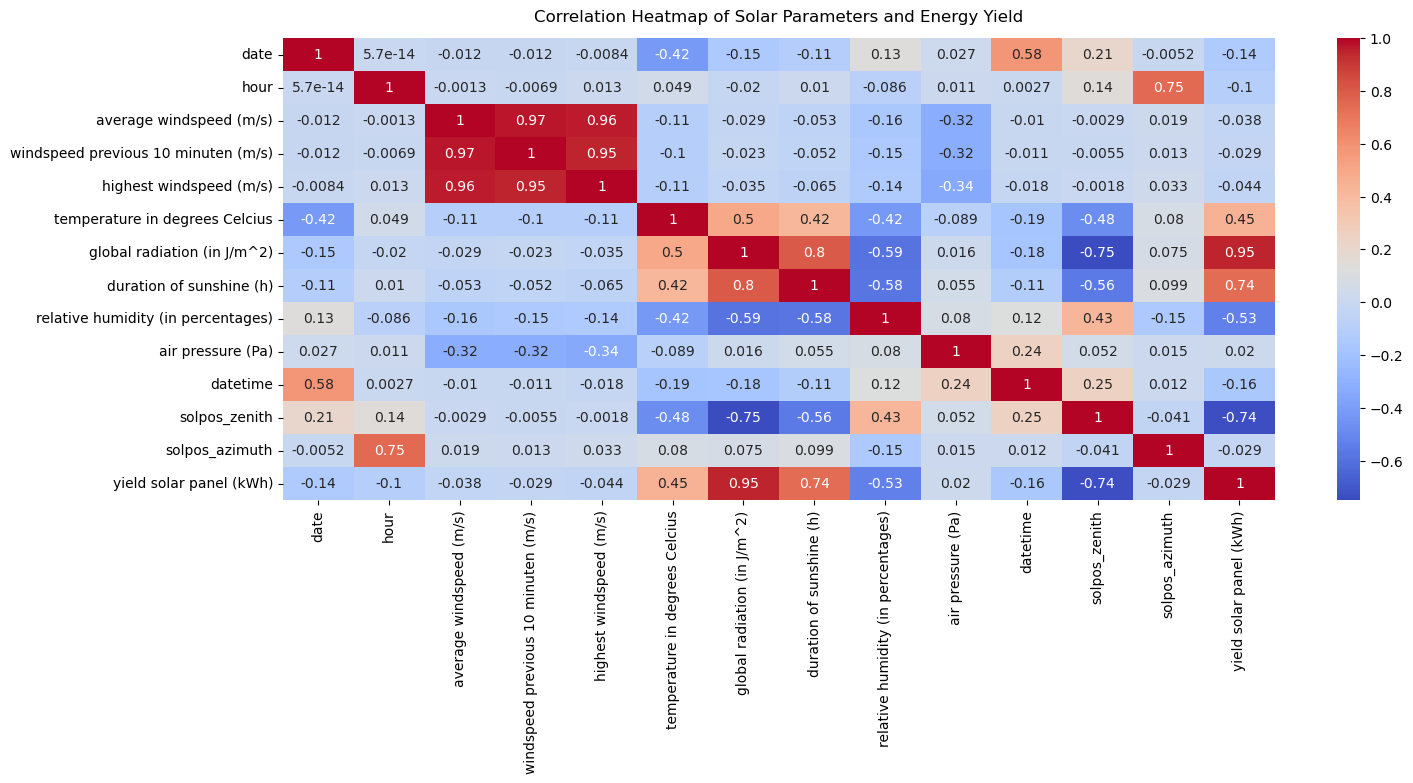

In [22]:
plt.figure(figsize=(16, 6))
heatmap=sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap of Solar Parameters and Energy Yield', fontdict={'fontsize':12}, pad=12);

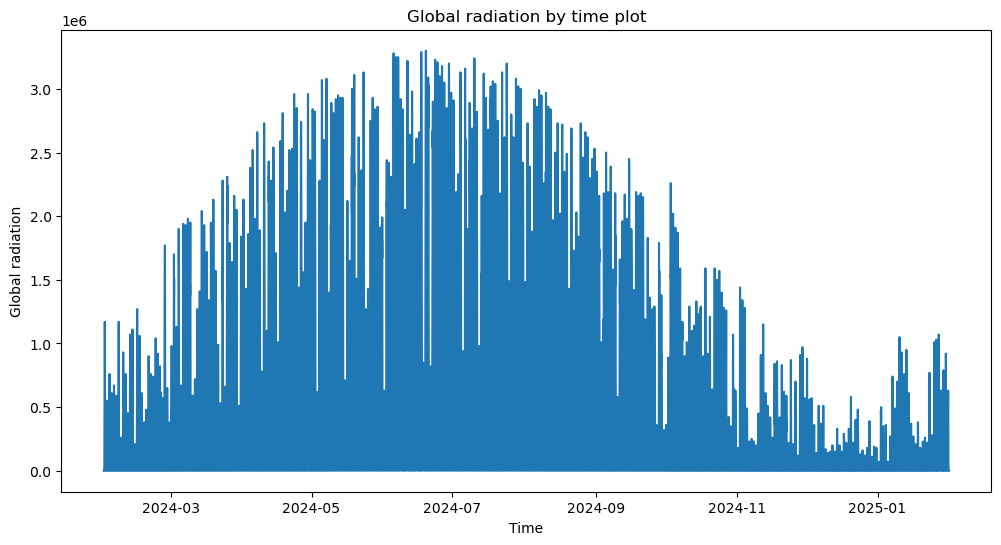

In [23]:
x= df.datetime
y = df['global radiation (in J/m^2)']
plt.figure(figsize=(12, 6))
plt.plot(x,y)#, height = df.solar_efficiency)
plt.xlabel("Time")
plt.ylabel("Global radiation")
plt.title("Global radiation by time plot")
plt.show()

##### Keeping only *`average windspeed (m/s)`* for wind data and drop the rest because all three have the same correlation. `datetime` is also dropped since we have `date` and `hour`.Then fill missing values with lowest value.
 

In [24]:
df=df.drop(["datetime","windspeed previous 10 minuten (m/s)", "duration of sunshine (h)", "highest windspeed (m/s)"],axis = "columns")

#### Handling `Null` values

###### Fill cells with Null value with zeros

In [25]:
min_wind_value= df['average windspeed (m/s)'].min()
min_air_pressure_value= df['air pressure (Pa)'].min()
print(min_wind_value)
df['average windspeed (m/s)'] = df['average windspeed (m/s)'].fillna(min_wind_value)
df['air pressure (Pa)']= df['air pressure (Pa)'].fillna(min_air_pressure_value)

0.0


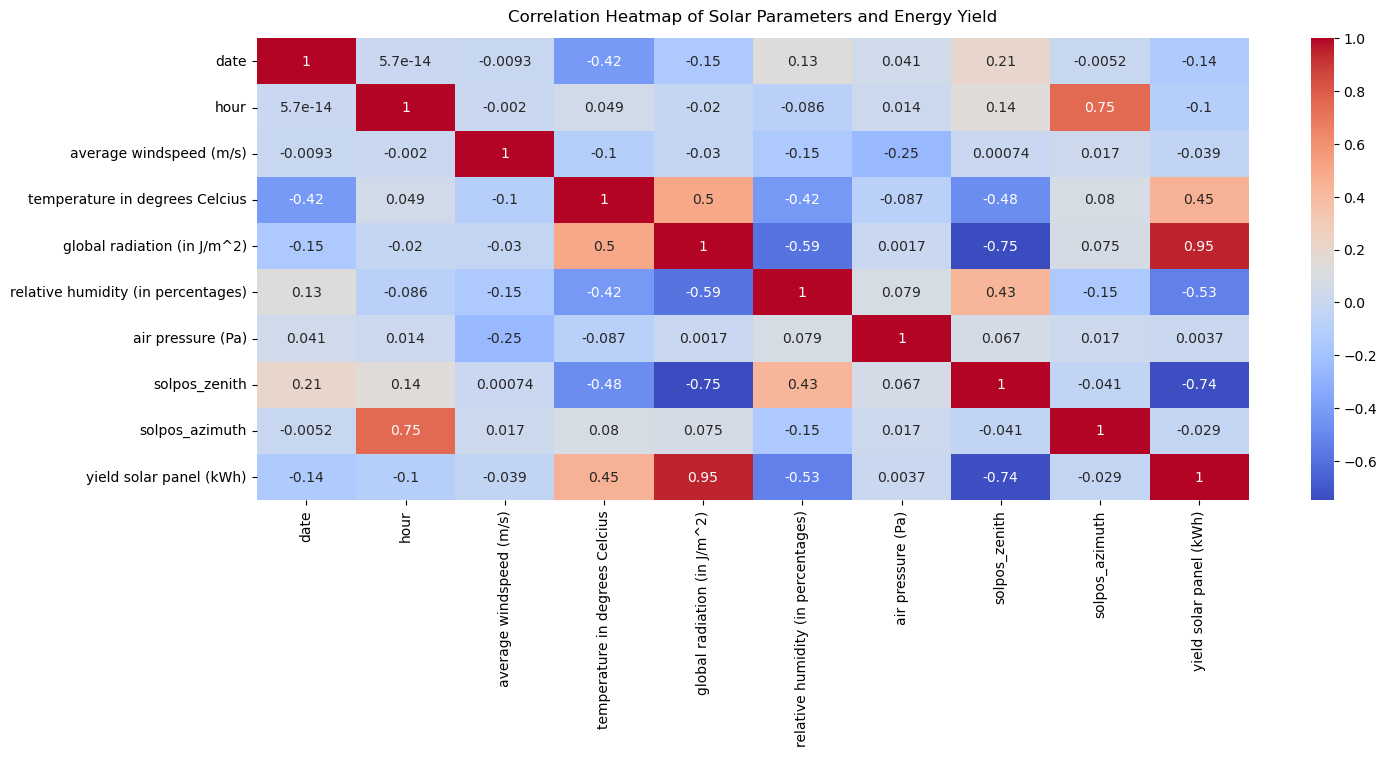

In [26]:
plt.figure(figsize=(16, 6))
heatmap=sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap of Solar Parameters and Energy Yield', fontdict={'fontsize':12}, pad=12);

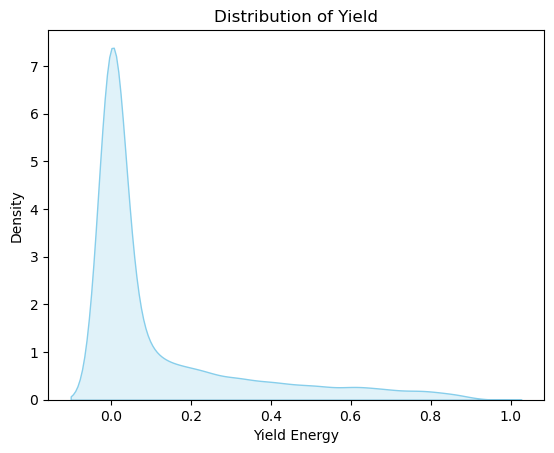

In [27]:
sns.kdeplot(df['yield solar panel (kWh)'], fill=True, color='skyblue')
plt.title('Distribution of Yield')
plt.xlabel('Yield Energy')
plt.ylabel('Density')
plt.show()

_The graph above shows that density is high when Yield value is between `0` to`0,1`_
_Trying to check at what time Yield is mostly `0`_

In [28]:
df[df['yield solar panel (kWh)']== 0.000000].hour.value_counts()

hour
01    366
03    366
24    366
23    366
22    366
02    366
21    365
04    325
20    277
05    237
19    211
06    177
18    155
07    118
17     89
08     48
16      9
Name: count, dtype: int64

In [29]:
df.sample(5)

,date,hour,average windspeed (m/s),temperature in degrees Celcius,global radiation (in J/m^2),relative humidity (in percentages),air pressure (Pa),solpos_zenith,solpos_azimuth,yield solar panel (kWh)
8004,20241230,13,90.0,85,190000.0,87,10270.0,76.794027,197.358600,0.057324
212,20240209,21,70.0,114,0.0,80,9832.0,128.645024,299.833177,0.000000
6752,20241108,09,50.0,57,90000.0,86,10288.0,75.818645,143.683900,0.047480
2170,20240501,11,30.0,164,2710000.0,79,10080.0,37.555241,163.786600,0.804964
1388,20240329,21,70.0,121,0.0,69,9950.0,113.838175,313.093676,0.000000


#### Modelling using Multiple Linear Regression

##### Separate Dependent and independent variables

In [30]:
X = df.drop(["yield solar panel (kWh)"],axis = "columns")
y = df["yield solar panel (kWh)"]
print(X.head())

       date hour  average windspeed (m/s)  temperature in degrees Celcius  global radiation (in J/m^2)  relative humidity (in percentages)  air pressure (Pa)  solpos_zenith  solpos_azimuth
0  20240201   01                    100.0                              90                          0.0                                  96            10243.0     143.162709       25.600065
1  20240201   02                    100.0                              87                          0.0                                  94            10250.0     137.699864       46.486728
2  20240201   03                     90.0                              72                          0.0                                  85            10260.0     130.125118       63.429047
3  20240201   04                     70.0                              65                          0.0                                  84            10269.0     121.419409       77.487555
4  20240201   05                     70.0              

In [31]:
X.columns

Index(['date', 'hour', 'average windspeed (m/s)', 'temperature in degrees Celcius', 'global radiation (in J/m^2)', 'relative humidity (in percentages)', 'air pressure (Pa)', 'solpos_zenith', 'solpos_azimuth'], dtype='object')

##### Using the RandomForestRegressor to rank feature impontance as another way of correlation

In [32]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X,y)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

                              Feature  Importance
4         global radiation (in J/m^2)    0.896714
8                      solpos_azimuth    0.043326
1                                hour    0.042983
7                       solpos_zenith    0.016145
0                                date    0.000243
6                   air pressure (Pa)    0.000175
5  relative humidity (in percentages)    0.000157
3      temperature in degrees Celcius    0.000150
2             average windspeed (m/s)    0.000109


_Given the result `global radiation` has the highest importance(influence on the `Energy yield`) among all the features of `89%` when the second and third has `4.6` and `4.0%` respectively_

##### _Selecting only features with high importance_

In [33]:
selected_features = ['hour','global radiation (in J/m^2)','solpos_zenith', 'solpos_azimuth']

In [34]:
X_selected = df[selected_features]

In [35]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X_selected)

# Print the scaled data
print(X_scaled)

[[-1.66132477 -0.59999869  1.78419833 -1.47801586]
 [-1.51686175 -0.59999869  1.60188118 -1.27356129]
 [-1.37239873 -0.59999869  1.34908137 -1.10771697]
 ...
 [ 1.37239873 -0.59999869  1.61833504  1.35954139]
 [ 1.51686175 -0.59999869  1.79046565  1.56760448]
 [ 1.66132477 -0.59999869  1.84946929 -1.71688469]]


#### _Spliting `train` and `test` data `80%` and `20%` respectivelly and run the `Linear Regression model`_

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# The 'LinearRegression' model is initialized and fitted to the training data.
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# The model is used to predict the target variable for the test set.
y_pred = lin_model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


Mean Squared Error: 0.0036815892177095967
R-squared: 0.9098335925226186


##### _Plotting residual_

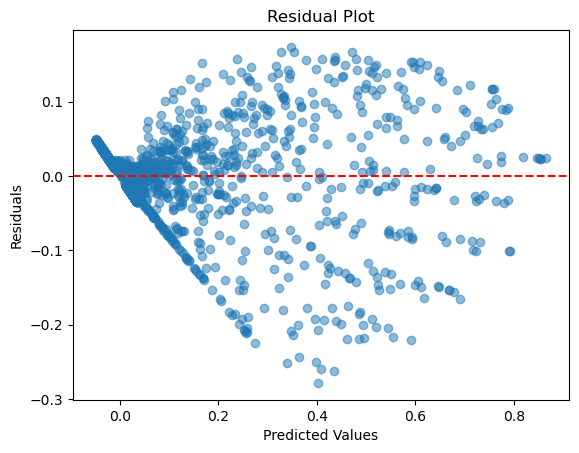

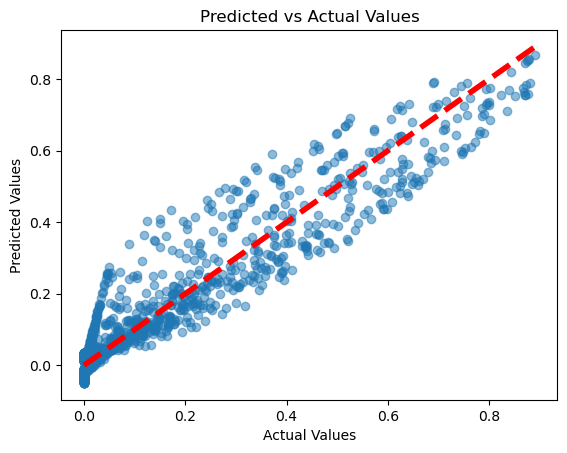

In [37]:
# Residual Plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Predicted vs Actual Plot
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=4)
plt.show()

##### Using Statsmodel to get how much a feature can contribute to the Yield 

                               OLS Regression Results                              
Dep. Variable:     yield solar panel (kWh)   R-squared:                       0.915
Model:                                 OLS   Adj. R-squared:                  0.915
Method:                      Least Squares   F-statistic:                 1.896e+04
Date:                     Tue, 24 Jun 2025   Prob (F-statistic):               0.00
Time:                             22:28:48   Log-Likelihood:                 9805.1
No. Observations:                     7027   AIC:                        -1.960e+04
Df Residuals:                         7022   BIC:                        -1.957e+04
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

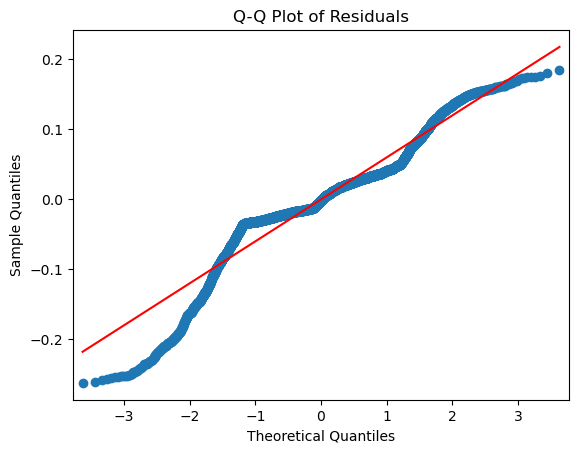

In [38]:
import statsmodels.api as sm

# Add a constant to the model
X_train_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_sm).fit()
print(model_sm.summary())

# Q-Q Plot for residuals
sm.qqplot(model_sm.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [41]:
january2024_df = pd.read_csv('~/Documents/Soleil/Lectoraar-Internship/Solar-Panel-Project/Energy/df_KNMI.csv')

In [42]:
january2024_df["HH"] = january2024_df["HH"].astype(str).str.zfill(2)

In [43]:
january2024_df = january2024_df.drop(columns = drop_columns)
january2024_df = january2024_df.rename(columns = new_column_names)

In [52]:
january2024_df.head()

,Unnamed: 0,date,hour,average windspeed (m/s),windspeed previous 10 minuten (m/s),highest windspeed (m/s),temperature in degrees Celcius,global radiation (in J/m^2),duration of sunshine (h),relative humidity (in percentages),air pressure (Pa),datetime,solpos_zenith,solpos_azimuth
0,0,20240101,01,120,120,180,75,0,0,91,9951,2024-01-01 01:00:00,147.847274,32.920517
1,1,20240101,02,90,100,150,74,0,0,91,9958,2024-01-01 02:00:00,141.460269,54.207034
2,2,20240101,03,100,110,160,92,0,0,79,9959,2024-01-01 03:00:00,133.271369,70.685595
3,3,20240101,04,110,110,190,91,0,0,80,9966,2024-01-01 04:00:00,124.266964,84.137301
4,4,20240101,05,100,100,150,95,0,0,76,9973,2024-01-01 05:00:00,115.042669,95.966753


In [48]:
def parse_datetime(row):
    hour = int(row["hour"])
    date = pd.to_datetime(str(row["date"]), format="%Y%m%d")
    if hour == 24:
        return date + pd.Timedelta(days=1)
    else:
        return date + pd.Timedelta(hours=hour)

january2024_df["datetime"] = january2024_df.apply(parse_datetime, axis=1)

In [50]:
# Calculate the positions of the sun
date_time_or_doy = january2024_df['datetime'] 
solpos = get_solarposition(
    time = date_time_or_doy, latitude = lat,
    longitude = lon, altitude = elevation_module,
    pressure = january2024_df['air pressure (Pa)'].values, 
    temperature = january2024_df['temperature in degrees Celcius'].values) 

In [51]:
january2024_df['solpos_zenith'] = solpos['zenith'].values
january2024_df['solpos_azimuth'] = solpos['azimuth'].values

In [53]:
new_X_selected=january2024_df[selected_features]

In [55]:
new_X_selected.sample(3)

,hour,global radiation (in J/m^2),solpos_zenith,solpos_azimuth
53,06,0,106.009057,106.821941
715,20,0,122.624916,283.573903
294,07,0,97.001186,116.340600


In [56]:
new_scaler = StandardScaler()

# Fit the scaler to the data and transform it
new_X_scaled = new_scaler.fit_transform(new_X_selected)

# Print the scaled data
print(new_X_scaled)

[[-1.66132477 -0.49760788  1.51392428 -1.5242534 ]
 [-1.51686175 -0.49760788  1.27015914 -1.29482024]
 [-1.37239873 -0.49760788  0.9576232  -1.11720881]
 ...
 [ 1.37239873 -0.49760788  1.15323595  1.52007546]
 [ 1.51686175 -0.49760788  1.35049783  1.74983693]
 [ 1.66132477 -0.49760788  1.41797169 -1.86560532]]


In [59]:
len(lin_model.predict(new_X_selected))

744